# TP 3 : job d'entraînement, déploiement de modèle, prédiction par batch et en ligne

### Objectifs

Au cours de ce TP, vous apprendrez à créer un modèle de Vision personnalisé, vous configurerez et lancerez un job d'entraînement, enfin, vous déploierez le modèle pour de la prédiction par lot (batch) puis pour de la prédiction en ligne (streaming). 

On utilisera les services Google Cloud ML suivant :

- Vertex AI Training
- Vertex AI Batch Prediction
- Vertex AI Model resource

Quelques liens utiles :
- [Custom training](https://cloud.google.com/vertex-ai/docs/training/custom-training) 
- [Vertex AI Batch Prediction](https://cloud.google.com/vertex-ai/docs/tabular-data/classification-regression/get-batch-predictions)

### Dataset

TensorFlow met à disposition de nombreux datasets issues de domaines variés et pensés pour le machine learning : [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview). 

Pour mettre tout ceci en pratique, on utilisera les données [cifar10 dataset](https://www.tensorflow.org/datasets/catalog/cifar10) et on développera un modèle de Computer Vision avec TensorFlow afin de prédire la nature des objets présents sur les images parmi 10 catégories possibles : avion, voiture, oiseau, chat, cerf, chien, grenouille, cheval, bateau, camion.

# Mise en place de l'environnement

### Installer Vertex AI SDK for Python et autres


In [11]:
pip install -r requirements.txt

  Using cached pillow-10.2.0-cp311-cp311-win_amd64.whl.metadata (9.9 kB)
  Using cached numpy-1.22.0.zip (11.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement backports.tarfile==0.4.0 (from versions: 1.0.0, 1.1.0, 1.1.1, 1.2.0)
ERROR: No matching distribution found for backports.tarfile==0.4.0


### Variables du projet Google Cloud and initialisation du SDK

In [12]:
PROJECT_ID = "projet-ia-448520"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

#### Renseigner le chemin du Cloud Storage bucket

Le bucket permettra de stocker les datasets et le modèle

In [13]:
BUCKET_URI = f"gs://cours3bucket"

**Si vous n'avez pas de bucket** : Décommentez la cellule suivante afin de créer un bucket.

In [14]:
#! gsutil mb -l $LOCATION -p $PROJECT_ID $BUCKET_URI

#### Initialisation du SDK Python

Le SDK python permet d'utiliser l'API de Google Cloud Platform avec du code plutôt qu'avec l'interface utilisateur.

In [15]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=LOCATION, staging_bucket=BUCKET_URI)

### Import des librairies python

In [16]:
import os
import numpy as np
from PIL import Image

### Mise en place des conteneurs docker pré-construit

On utilisera ici des conteneurs dockeurs pré-construits, fournis par Vertex AI, qui permettent à nos codes d'entrainement et de prédiction de tourner sans encombre sur les machines virtuelles de GCP. 

Puisque l'on utilise des conteneurs pré-construits, il suffit de fournir un code python pour l'entrainement puis de préciser le nom de deux conteneurs parmi les listes suivantes : [Pre-built containers for training](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers) et [Pre-built containers for prediction](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers), en prenant garde à ce que ces conteneurs fournissent des environnements adaptés à notre projet et aux machines que l'on souhaite utiliser. (Veuillez consulter les liens pour adapter le conteneur à votre version de python) 

In [17]:
TRAIN_VERSION = "tf-cpu.2-9"
DEPLOY_VERSION = "tf2-cpu.2-9"

TRAIN_IMAGE = "us-docker.pkg.dev/vertex-ai/training/{}:latest".format(TRAIN_VERSION)
DEPLOY_IMAGE = "us-docker.pkg.dev/vertex-ai/prediction/{}:latest".format(DEPLOY_VERSION)

Le code pour l'inférence n'aura pas à être écrit. En effet, le conteneur de prédiction pré-construit contient un serveur d'inférence qui chargera les poids de notre modèle entrainé pour servir des prédictions.

# PART 1: Entraînement d'un modèle

Nous allons maintenant créer un modèle de vision et nous l'entraînerons sur les données CIFAR10.

#### Écrire un script d'entrainement

La prochaine cellule vise à écrire le fichier `task.py` qui contient le script de définition et d'entrainement de notre modèle. On suit les étapes suivante :

- Récuperer les paramètres de l'entrainement en parsant les arguments. 
- Récupérer le chemin du répertoire `AIP_MODEL_DIR` où les artefacts de notre modèle seront enregistrés. La variable sera fixée par le service d'entrainement.
- Charger le CIFAR10 dataset.
- Définir un modèle CNN avec tensortlow.Keras.
- Compiler le modèle (`compile()`).
- Mettre en place la statégie de distribution des calculs précisée par `args.distribute`.
- Entrainer le modèle (`fit()`) avec les paramètres : `args.epochs` et `args.steps`
- Sauvegarder le modèle à l'emplacement spécifié (`save(MODEL_DIR)`)

In [14]:
%%writefile task.py
# Single, Mirror and Multi-Machine Distributed Training for CIFAR-10

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.python.client import device_lib
import argparse
import os
import sys
tfds.disable_progress_bar()

parser = argparse.ArgumentParser()
parser.add_argument('--lr', dest='lr',
                    default=0.01, type=float,
                    help='Learning rate.')
parser.add_argument('--epochs', dest='epochs',
                    default=10, type=int,
                    help='Number of epochs.')
parser.add_argument('--steps', dest='steps',
                    default=200, type=int,
                    help='Number of steps per epoch.')
parser.add_argument('--distribute', dest='distribute', type=str, default='single',
                    help='distributed training strategy')
args = parser.parse_args()

print('Python Version = {}'.format(sys.version))
print('TensorFlow Version = {}'.format(tf.__version__))
print('TF_CONFIG = {}'.format(os.environ.get('TF_CONFIG', 'Not found')))
print('DEVICES', device_lib.list_local_devices())

# Single Machine, single compute device
if args.distribute == 'single':
    if tf.test.is_gpu_available():
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    else:
        strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
# Single Machine, multiple compute device
elif args.distribute == 'mirror':
    strategy = tf.distribute.MirroredStrategy()
# Multiple Machine, multiple compute device
elif args.distribute == 'multi':
    strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

# Multi-worker configuration
print('num_replicas_in_sync = {}'.format(strategy.num_replicas_in_sync))

# Preparing dataset
BUFFER_SIZE = 10000
BATCH_SIZE = 64

def make_datasets_unbatched():
    # Scaling CIFAR10 data from (0, 255] to (0., 1.]
    def scale(image, label):
        image = tf.cast(image, tf.float32)
        image /= 255.0
        return image, label
    
    datasets, info = tfds.load(name='cifar10',
                            with_info=True,
                            as_supervised=True)
    return datasets['train'].map(scale).cache().shuffle(BUFFER_SIZE).repeat()


# Build the Keras model
def build_and_compile_cnn_model():
    model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(32, 32, 3)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
      loss=tf.keras.losses.sparse_categorical_crossentropy,
      optimizer=tf.keras.optimizers.SGD(learning_rate=args.lr),
      metrics=['accuracy'])
    return model

# Train the model
NUM_WORKERS = strategy.num_replicas_in_sync
# Here the batch size scales up by number of workers since
# `tf.data.Dataset.batch` expects the global batch size.
GLOBAL_BATCH_SIZE = BATCH_SIZE * NUM_WORKERS
MODEL_DIR = os.getenv("AIP_MODEL_DIR")

train_dataset = make_datasets_unbatched().batch(GLOBAL_BATCH_SIZE)

with strategy.scope():
    # Creation of dataset, and model building/compiling need to be within
    # `strategy.scope()`.
    model = build_and_compile_cnn_model()

model.fit(x=train_dataset, epochs=args.epochs, steps_per_epoch=args.steps)
model.save(MODEL_DIR)

Overwriting task.py


### Arguments d'entraînement

Le code que l'on a écrit prend les arguments suivant en entrée :

- `args`: 
  - `"--epochs=" + EPOCHS`: Nombre d'epochs.
  - `"--steps=" + STEPS`: Nombre de lot par epoch.
  - `"--distribute=" + TRAIN_STRATEGY"` : Stratégie de distributions des calculs pour l'entraînement.
     - `"single"`: une seule machine.
     - `"mirror"`: tous les GPU sur une seule instance de calcul.
     - `"multi"`: tous les GPU sur toutes les instances de calcul.
     
On précisera dans la cellule suivante les paramètres à utiliser.

In [15]:
JOB_NAME = "custom_job_unique"
MODEL_DIR = "{}/{}".format(BUCKET_URI, JOB_NAME)


TRAIN_STRATEGY = "single"

EPOCHS = 60
STEPS = 100

CMDARGS = [
    "--epochs=" + str(EPOCHS),
    "--steps=" + str(STEPS),
    "--distribute=" + TRAIN_STRATEGY,
]

### Entraîner le modèle

Nous allons maintenant définir un job d'entraînement.

On utilise la classe `CustomTrainingJob` qui prend les paramètres suivant :

- `display_name`: Le nom du job à définir.
- `script_path`: Le chemin vers le script `task.py` à utiliser.
- `container_uri`: The URI of the training container image.
- `requirements`: The list of Python package dependencies of the script.
- `model_serving_container_image_uri`: L'adresse de l'image du conteneur à utiliser, pré-construit ou personnalisé.

On peut ensuite lancer le job avec la fonction `run`, il faut préciser les paramètres suivant :

- `args`: Les arguments du script python que l'on a renseigné.
- `replica_count`: Le nombre de worker.
- `model_display_name`: Le nom à afficher du `Model` que le script va produire.
- `machine_type`: Le type de machine. ex: "n1-standard-8"
- `accelerator_type`: Le type d'accelerateur (GPU, TPU). ex: "NVIDIA_TESLA_T4"
- `accelerator_count`: Le nombre d'accélérateur à attacher par worker. ex: 1

In [16]:
job = aiplatform.CustomTrainingJob(
    display_name=JOB_NAME,
    script_path="task.py",
    container_uri=TRAIN_IMAGE,
    requirements=["tensorflow_datasets==1.3.0"],
    model_serving_container_image_uri=DEPLOY_IMAGE,
)

MODEL_DISPLAY_NAME = "model_unique"

# Start the training

model = job.run(
    model_display_name=MODEL_DISPLAY_NAME,
    args=CMDARGS,
    replica_count=1,
)

Training script copied to:
gs://cours3bucket/aiplatform-2025-02-26-17:26:44.280-aiplatform_custom_trainer_script-0.1.tar.gz.
Training Output directory:
gs://cours3bucket/aiplatform-custom-training-2025-02-26-17:26:44.560 
View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/103626737534894080?project=837843744498
View backing custom job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/2393869875773702144?project=837843744498
CustomTrainingJob projects/837843744498/locations/us-central1/trainingPipelines/103626737534894080 current state:
3
CustomTrainingJob projects/837843744498/locations/us-central1/trainingPipelines/103626737534894080 current state:
3
CustomTrainingJob projects/837843744498/locations/us-central1/trainingPipelines/103626737534894080 current state:
3
CustomTrainingJob projects/837843744498/locations/us-central1/trainingPipelines/103626737534894080 current state:
3
CustomTrainingJob projects/837843744498/l

Veuillez vérifier que le job est bien terminé en ouvrant la console GCP sur votre navigateur. 

Donnez l'ID du Bucket où sont enregistré les artéfact du model 

In [ ]:
#Réponse

# PART 2 : Inférence par lot

Nous allond maintenant utiliser le modèle pour faire de la prédiction par lot (batch).

### Données de test

#### téléchargement des données

Télécharger et préparer les images du CIFAR dataset.

In [17]:
# Download the images
! gsutil -m cp -r gs://cloud-samples-data/ai-platform-unified/cifar_test_images .

Copying gs://cloud-samples-data/ai-platform-unified/cifar_test_images/image_0_3.jpg...
Copying gs://cloud-samples-data/ai-platform-unified/cifar_test_images/image_2_8.jpg...
/ [0/10 files][    0.0 B/  8.7 KiB]   0% Done                                   
/ [0/10 files][    0.0 B/  8.7 KiB]   0% Done                                   
Copying gs://cloud-samples-data/ai-platform-unified/cifar_test_images/image_0_6.jpg...
/ [0/10 files][    0.0 B/  8.7 KiB]   0% Done                                   
Copying gs://cloud-samples-data/ai-platform-unified/cifar_test_images/image_5_4.jpg...
/ [0/10 files][    0.0 B/  8.7 KiB]   0% Done                                   
Copying gs://cloud-samples-data/ai-platform-unified/cifar_test_images/image_2_9.jpg...
Copying gs://cloud-samples-data/ai-platform-unified/cifar_test_images/image_2_1.jpg...
/ [0/10 files][    0.0 B/  8.7 KiB]   0% Done                                   
Copying gs://cloud-samples-data/ai-platform-unified/cifar_test_images/ima

In [7]:
# Load image data
IMAGE_DIRECTORY = "cifar_test_images"

image_files = [file for file in os.listdir(IMAGE_DIRECTORY) if file.endswith(".jpg")]

# Decode JPEG images into numpy arrays
image_data = [
    np.asarray(Image.open(os.path.join(IMAGE_DIRECTORY, file))) for file in image_files
]

# Scale and convert to expected format
x_test = [(image / 255.0).astype(np.float32).tolist() for image in image_data]

# Extract labels from image name
y_test = [int(file.split("_")[1]) for file in image_files]

#### Préparer les données à la prediction par lot
Il existe plusieurs formats possibles pour l'enregistrement des données d'entrée d'un job de batch prediction.

On utilise ici le format JSONL.

Pour plus d'information : https://cloud.google.com/vertex-ai/docs/predictions/batch-predictions#batch_request_input

In [19]:
import json

BATCH_PREDICTION_INSTANCES_FILE = "batch_prediction_instances.jsonl"

BATCH_PREDICTION_GCS_SOURCE = (
    BUCKET_URI + "/batch_prediction_instances/" + BATCH_PREDICTION_INSTANCES_FILE
)

# Write instances at JSONL
with open(BATCH_PREDICTION_INSTANCES_FILE, "w") as f:
    for x in x_test:
        f.write(json.dumps(x) + "\n")

# Upload to Cloud Storage bucket*
! gsutil cp $BATCH_PREDICTION_INSTANCES_FILE $BATCH_PREDICTION_GCS_SOURCE

print("Uploaded instances to: ", BATCH_PREDICTION_GCS_SOURCE)


Uploaded instances to:  gs://cours3bucket/batch_prediction_instances/batch_prediction_instances.jsonl


Copying file://batch_prediction_instances.jsonl [Content-Type=application/octet-stream]...
/ [0 files][    0.0 B/617.6 KiB]                                                
/ [1 files][617.6 KiB/617.6 KiB]                                                
-

Operation completed over 1 objects/617.6 KiB.                                    


### Envoi de la requète de prédiction

Pour faire une requète de prédiction par lot, on appelle la méthode batch_predict du modèle avec les paramètres suivants :

- `instances_format` : Le format du fichier de demande de prédiction par lot : "jsonl", "csv", "bigquery", "tf-record", "tf-record-gzip" ou "file-list"
- `prediction_format` : Le format du fichier de réponse de prédiction par lot : "jsonl", "csv", "bigquery", "tf-record", "tf-record-gzip" ou "file-list"
- `job_display_name` : Le nom de la tâche de prédiction.
- `gcs_source` : Une liste d'un ou plusieurs chemins Cloud Storage vers les données sources. 
- `gcs_destination_prefix` : Le chemin Cloud Storage où le service écrira les prédictions.
- `model_parameters` : Paramètres de filtrage supplémentaires pour la diffusion des résultats de prédiction.
- `machine_type` : Le type de machine à utiliser pour l'entraînement.
- `accelerator_type` : Le type d'accélérateur matériel.
- `accelerator_count` : Le nombre d'accélérateurs à attacher à une réplique de travail.
- `starting_replica_count` : Le nombre d'instances de calcul à provisionner initialement.
- `max_replica_count` : Le nombre maximum d'instances de calcul auxquelles effectuer la mise à l'échelle. Dans ce tutoriel, une seule instance est provisionnée.

### Mise à l'échelle des instances de calcul
On utilise pour l'instant une seule instance (ou nœud) pour traiter les requêtes de prédiction par lot : les variables `MIN_NODES` et `MAX_NODES` sont toutes deux fixées à `1`.

Pour utiliser plusieurs nœuds dans la prédiction par lot, on peut définir `MAX_NODES` sur le nombre maximum de nœuds que l'on souhaite utiliser. Vertex AI met automatiquement à l'échelle le nombre de nœuds utilisés pour servir les prédictions, jusqu'au nombre maximum défini.

In [20]:
MIN_NODES = 1
MAX_NODES = 1

# The name of the job
BATCH_PREDICTION_JOB_NAME = "cifar10_batch_prediction_unique"

# Folder in the bucket to write results to
DESTINATION_FOLDER = "batch_prediction_results"

# The Cloud Storage bucket to upload results to
BATCH_PREDICTION_GCS_DEST_PREFIX = BUCKET_URI + "/" + DESTINATION_FOLDER

# Make SDK batch_predict method call
batch_prediction_job = model.batch_predict(
    instances_format="jsonl",
    predictions_format="jsonl",
    job_display_name=BATCH_PREDICTION_JOB_NAME,
    gcs_source=BATCH_PREDICTION_GCS_SOURCE,
    gcs_destination_prefix=BATCH_PREDICTION_GCS_DEST_PREFIX,
    model_parameters=None,
    starting_replica_count=MIN_NODES,
    max_replica_count=MAX_NODES,
    machine_type="n1-standard-4",
    sync=True,
    
)

Creating BatchPredictionJob
BatchPredictionJob created. Resource name: projects/837843744498/locations/us-central1/batchPredictionJobs/4016128913813012480
To use this BatchPredictionJob in another session:
bpj = aiplatform.BatchPredictionJob('projects/837843744498/locations/us-central1/batchPredictionJobs/4016128913813012480')
View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/4016128913813012480?project=837843744498
BatchPredictionJob projects/837843744498/locations/us-central1/batchPredictionJobs/4016128913813012480 current state:
3
BatchPredictionJob projects/837843744498/locations/us-central1/batchPredictionJobs/4016128913813012480 current state:
3
BatchPredictionJob projects/837843744498/locations/us-central1/batchPredictionJobs/4016128913813012480 current state:
3
BatchPredictionJob projects/837843744498/locations/us-central1/batchPredictionJobs/4016128913813012480 current state:
3
BatchPredictionJob projects/8378437444

### Récupérer les résultats

A la fin du job de prédiction, les résultats sont accessibles dans le répertoire de sortie que l'on a précisé dans un jsonl appelé prediction.results-xxxx-of-xxxx.

Pour chaque image, on obtient un vecteur de probabilité pour chacune des 10 classes du dataset.

In [21]:
RESULTS_DIRECTORY = "prediction_results"
RESULTS_DIRECTORY_FULL = RESULTS_DIRECTORY + "/" + DESTINATION_FOLDER

# Create missing directories
os.makedirs(RESULTS_DIRECTORY, exist_ok=True)


In [22]:
BATCH_PREDICTION_GCS_DEST_PREFIX

'gs://cours3bucket/batch_prediction_results'

In [23]:
# Get the Cloud Storage paths for each result
! gsutil -m cp -r $BATCH_PREDICTION_GCS_DEST_PREFIX $RESULTS_DIRECTORY

Copying gs://cours3bucket/batch_prediction_results/prediction-model_unique-2025_02_26T02_01_12_596Z/prediction.errors_stats-00000-of-00001...
Copying gs://cours3bucket/batch_prediction_results/prediction-model_unique-2025_02_21T07_18_35_602Z/prediction.errors_stats-00000-of-00001...
/ [0/6 files][    0.0 B/  1.8 MiB]   0% Done                                    
Copying gs://cours3bucket/batch_prediction_results/prediction-model_unique-2025_02_26T08_42_01_168Z/prediction.errors_stats-00000-of-00001...
Copying gs://cours3bucket/batch_prediction_results/prediction-model_unique-2025_02_26T08_42_01_168Z/prediction.results-00000-of-00001...
/ [0/6 files][    0.0 B/  1.8 MiB]   0% Done                                    
/ [0/6 files][    0.0 B/  1.8 MiB]   0% Done                                    
Copying gs://cours3bucket/batch_prediction_results/prediction-model_unique-2025_02_21T07_18_35_602Z/prediction.results-00000-of-00001...
/ [0/6 files][    0.0 B/  1.8 MiB]   0% Done             

In [24]:

# Get most recently modified directory
latest_directory = max(
    (
        os.path.join(RESULTS_DIRECTORY_FULL, d)
        for d in os.listdir(RESULTS_DIRECTORY_FULL)
    ),
    key=os.path.getmtime,
)

# Get downloaded results in directory
results_files = []
for dirpath, subdirs, files in os.walk(latest_directory):
    for file in files:
        if file.startswith("prediction.results"):
            results_files.append(os.path.join(dirpath, file))

# Consolidate all the results into a list
results = []
for results_file in results_files:
    # Download each result
    with open(results_file, "r") as file:
        results.extend([json.loads(line) for line in file.readlines()])

### Evaluer les résulats

Pour l'évaluation :
1. `np.argmax`: sélectionne le label prédit (avec la plus grande probabilité)
2. On compare ensuite la prédiction au label d'origine
3. On calcule l'`accuracy` $=$ `correct/total`

On pourra essayer d'autres paramètres d'entrainement pour augmenter les performances du modèle.

In [25]:
y_predicted = [np.argmax(result["prediction"]) for result in results]

correct = sum(y_predicted == np.array(y_test))
total_predictions = len(y_predicted)
print(
    f"Correct predictions = {correct}, Total predictions = {total_predictions}, Accuracy = {correct/total_predictions}"
)

Correct predictions = 4, Total predictions = 10, Accuracy = 0.4


# Partie 4 : Prédiction en ligne

### Déployer le modèle sur un endpoint

Avant de pouvoir obtenir des prédictions, le modèle doit être déployé sur un `Endpoint`. L'endpoint est un serveur qui tourne sur les ressources qu'on définit au préalable. Il gère les requêtes qu'il reçoit au format HTTP et distribue les calculs pour une réponse avec un minimum de latence.

On utilisera la fonction `deploy` qui prend en entrée :

- `deployed_model_display_name`: Un nom pour le modèle deployé
- `traffic_split`: Le pourcentage du trafic de l'endpoint qui va être transmis aux différents modèles de l'edpoint.
   - On précisera la répartition du trafic sous forme de dictionnaire python où les clés sont les id des modèles et les valeurs sont les pourcentages de trafic qui doivent sommer à 100. On utilise "0" pour la clé du modèle que l'on déploie. Ex : *{ "0": percent, model_id: percent, ... }**
- `machine_type`: Le type de machine pour l'entraînement.
- `accelerator_type`: Le type d'accelerateur (GPU, TPU).
- `accelerator_count`: Le nombre d'accelerateur par worker.
- `starting_replica_count`: Le nombre initial d'instance de calcul.
- `min_replica_count`: Le nombre minimum d'instances de calcul que Vertex AI doit attribuer à l'endpoint.
- `max_replica_count`: Le nombre maximum d'instances de calcul que Vertex AI puisse attribuer à l'endpoint pour l'_autoscaling_.

### Traffic split

Le `traffic_split` est généralement utilisé pour introduire graduellement un nouveau modèle en production. C'est ce qu'on appelle l'A/B testing, et cela permet de comparer les performances d'un nouveau modèle en production tout en minimizant le risque d'un changement brutal pour la plupart des utilisateurs.

In [13]:
DEPLOYED_NAME = "cifar10_deployed_unique"

TRAFFIC_SPLIT = {"0": 100}

MIN_NODES = 1
MAX_NODES = 1

#model = aiplatform.Model('3904388879976759296')

endpoint = model.deploy(
    deployed_model_display_name=DEPLOYED_NAME,
    machine_type='n1-highcpu-4',
    traffic_split=TRAFFIC_SPLIT,
    min_replica_count=MIN_NODES,
    max_replica_count=4,
)

Creating Endpoint
Create Endpoint backing LRO: projects/837843744498/locations/us-central1/endpoints/3863531027888603136/operations/8263665614652964864
Endpoint created. Resource name: projects/837843744498/locations/us-central1/endpoints/3863531027888603136
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/837843744498/locations/us-central1/endpoints/3863531027888603136')
Deploying model to Endpoint : projects/837843744498/locations/us-central1/endpoints/3863531027888603136
Deploy Endpoint model backing LRO: projects/837843744498/locations/us-central1/endpoints/3863531027888603136/operations/5904623834840956928
Endpoint model deployed. Resource name: projects/837843744498/locations/us-central1/endpoints/3863531027888603136


#### Préparer les images

Les images qui seront envoyés à l'endpoint doivent être _préprocessées_ afin qu'elles soient au même format que le format d'entrée du script d'entraînement `task.py`.

Préparer un batch d'image a envoyer a l'endpoint afin d'obtenir les meme résultats que lors de l'inférence précédente

In [ ]:
#Etudiant script 

In [27]:
import os
import numpy as np
from PIL import Image

# Load image data
IMAGE_DIRECTORY = "cifar_test_images"

image_files = ... # list of paths

# Decode JPEG images into numpy arrays
image_data = ...

# Scale and convert to expected format
x_test = ...

# Extract labels from image name
y_test = ...

In [36]:
len(x_test)

10

### Envoyer les requêtes de prédiction

On utilise la méthode `predict` de l'objet `Endpoint`. La fonction retourne une liste où chaque élément correspond à une image de la requête. 

Dans la cellule suivante, on lance une évaluation des résultats de prédiction comme pour la prédiction par bacth, on ne devrait pas observer de changement de performance.

In [35]:
# A priori, l'endpoint est déja chargé à ce stade. Sinon :
# endpoint = aiplatform.Endpoint(ENDPOINT_ID)

predictions = endpoint.predict(instances=x_test)
y_predicted = np.argmax(predictions.predictions, axis=1)

correct = sum(y_predicted == np.array(y_test))
total_predictions = len(y_predicted)
print(
    f"Correct predictions = {correct}, Total predictions = {total_predictions}, Accuracy = {correct/total_predictions}"
)

Correct predictions = 2, Total predictions = 10, Accuracy = 0.2


# Part 5 : Montée en charge de l'endpoint 

Dans cette partie nous allons tester la capacité de notre endpoint a pouvoir monter en charge. Dans un cas d'usage où nous constuisons une application ayant comme vocation a recevoir beacuoup de connexion, 
nous devons nous assurer que les modèles ont cette capacité a traiter ce traffic. 

Ainsi, nous allons utiliser la librairie Locust, elle permet de réaliser des test de charge sur des API. 

Le code api.py contient déjà tous les élément permettant de construire une API qui héberge notre endpoint. 

- Il vous faut dans un premier temps remplacer les variables PROJECT_ID, LOCATION, BUCKET_URI, ID_ENDPOINT par les variables que vous avez utilisé précédemment

- Pour déployé l'API en local, veuillez lancer la commande suivante $python -m unicorn api:app --reload --port 8080 (veuillez vérifier en amont que vous possédez bien les librairie FastAPi et uvicorn)

- Ensuite, ouvrez le script locust.py vérifiez bien que la fonction load_data() fonctionne dans votre cas. et adapter le script pour que l'appel ne comportant qu'une seule image. 


- Lancer l'application locust avec la commande $locust -f locustfile.py (!! librairie nécessaire locust, PyYAML, flask !!) 

Réalisez plusieurs test de votre endpoint 

Ex: 

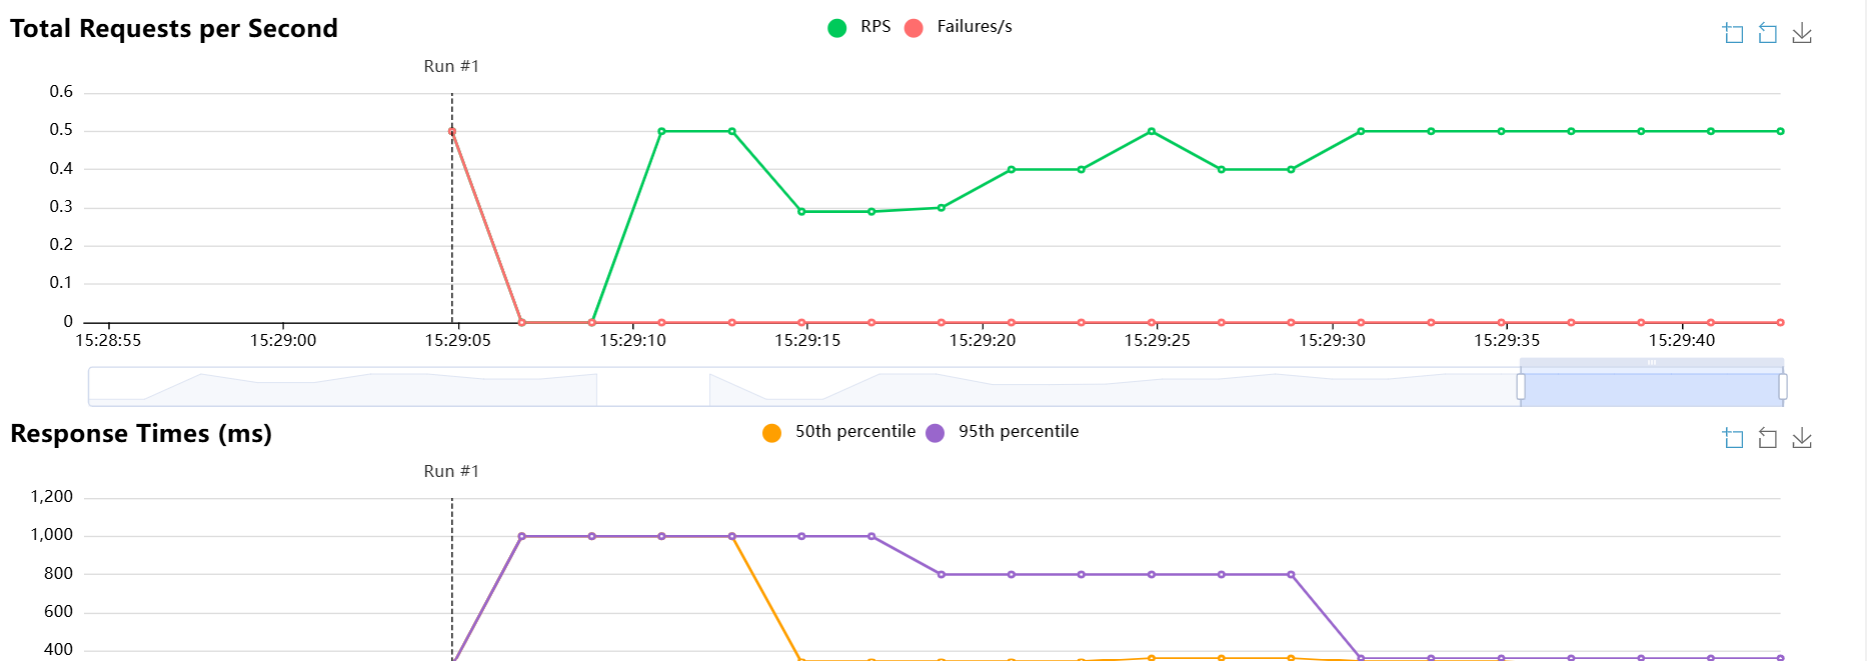

Q2 : Quels sont les limites de l'endpoint ? Avez vous pu observer la scalabilité automatique de vertexAI ? (Argumentez avec des graphs)

Q3 : Est ce que les limitations observé sont uniquement du au endpoint vertexAI ?

Q4 : Mise en situation, j'ai développé une application mobile pour une grande marque de vétements, qui permet de prendre une photo d'un habits et de retrouver un article similaire dans leur shop. Le modèle utilisé est similaire a celui de notre exemple. Nous avons déployé ce modèle sur un endpoint VertexAI. L'application a été téléchargé plus de 50 000 fois, on estime qu'un utilisateur fais une recherche par jour. Pouvez vous dire si cette méthode de déploiement est viable pour notre application ? (Ouvert)

# Nettoyage du projet

In [69]:
# Delete the training job
job.delete()

# Delete the model
model.delete()

Deleting CustomTrainingJob : projects/837843744498/locations/us-central1/trainingPipelines/5233020004923867136


NotFound: 404 Job "projects/837843744498/locations/us-central1/trainingPipelines/5233020004923867136" does not exist.